<a href="https://colab.research.google.com/github/laplaceconsulting/python_finance/blob/main/An%C3%A1lise_Elei%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Como fica minha carteira nos períodos de eleição?



Pensando que as eleições presidenciais estão chegando, é proposta aqui uma análise tanto do período pré-eleição como do desempenho de determinadas carteiras nos períodos de eleição em si. Os anos de eleição são naturalmente marcados por momentos de volatilidade elevada e incerteza. Conforme os cenários vão se consolidando o mercado tende a responder melhor.

##1. Eleições 2006

Segundo ano de mandato de Lula, ainda com forte apoio popular,o que vinha se refletindo nas pesquisas. O PSDB alterna o candidato trocando José Serra por Geraldo Alckimin.

Contexto econômico:

- PIB (USD): 1.107,6
- Dívida/Pib: 55,4%
- Desemprego: 8,64%
- IPCA Acumulado: 3,14%

Primeiro Turno
- Lula 48,1%
- Geraldo Alckimin 41,6%
- Heloisa Helena 6,8%

Segundo Turno
- Lula 60,8%
- Geraldo Alckimin 39,2%

Instalando Bibliotecas

In [2]:
!pip install investpy
!pip install plotly

     |████████████████████████████████| 4.4 MB 35.3 MB/s 
     |████████████████████████████████| 235 kB 50.4 MB/s 
     |████████████████████████████████| 6.3 MB 44.6 MB/s 
     |████████████████████████████████| 503 kB 53.7 MB/s 
  Created wheel for investpy: filename=investpy-1.0.7-py3-none-any.whl size=4495221 sha256=7a4860f38d7f41e894528eec1667267884b6007e77a2b3518d1674b71b01273f
  Stored in directory: /root/.cache/pip/wheels/50/bb/ee/760eeb6cc7ed8efc1b1b23b13b6b9f17fb1ed530fb04bd16f5
Successfully built investpy
  Attempting uninstall: pytz
    Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


Importando Bibliotecas

In [3]:
import investpy
import pandas as pd
import numpy as np
import plotly.graph_objects as go

Análise da janela de volatilidade do IBOV

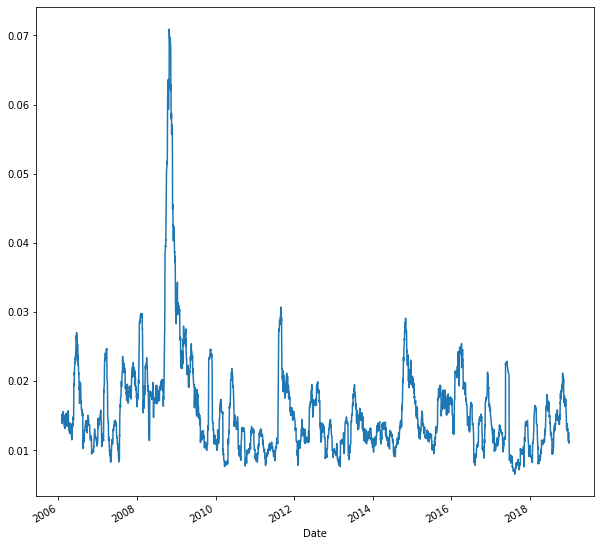

In [4]:
#gráfico janela de volatilidade 30 dias IBOV

ibov = investpy.get_index_historical_data('Bovespa', country='Brazil', from_date='01/01/2006', to_date='31/12/2018').Close
ibov_ret = ibov.pct_change()
ibov_vol = ibov_ret.rolling(22).std()
ibov_vol.plot(figsize=(10,10));

Definição dos pesos e das carteiras

- Carteira 1 vai ter uma alocação 50% IBOV 50% Dólar
- Carteira 2 vai ter a alocação 80% CDI 20% IBOV


In [7]:
pesos = np.array([0.5,0.5])
pesos2 = np.array([0.8,0.2])

In [9]:
#Construir a função analise_eleiçoes

def analise_eleicoes(data_inicio,data_fim):
  cesta = pd.DataFrame()
  #Ibov
  ibov = investpy.get_index_historical_data('Bovespa', country='Brazil', from_date=data_inicio, to_date=data_fim).Close
  ibov_ret = ibov.pct_change()
  ibov_ret = (1+ibov_ret).cumprod()
  cesta['IBOV'] = ibov_ret
  #CDI
  url = 'http://api.bcb.gov.br/dados/serie/bcdata.sgs.{}/dados?formato=json'.format(12)
  cdi = pd.read_json(url)
  cdi['data']=pd.to_datetime(cdi['data'], dayfirst=True)
  cdi.set_index('data', inplace=True)
  cdi = (1+cdi[data_inicio:data_fim]/100).cumprod()
  cesta['CDI'] = cdi
  #Dolar
  dol = investpy.get_currency_cross_historical_data('USD/BRL', from_date=data_inicio, to_date=data_fim).Close
  dol_ret = dol.pct_change()
  dol_ret = (1+dol_ret).cumprod()
  cesta['DOL'] = dol_ret
  #Carteira 50% IBovespa 50% Dolar
  base_carteira_1 = pd.merge(ibov, dol, how='inner', left_index=True,right_index=True)
  retorno_carteira1 = base_carteira_1.pct_change()
  retorno_carteira1 = (retorno_carteira1 * pesos).sum(axis=1)
  retorno_acm_carteira = (1+retorno_carteira1).cumprod()
  cesta['IBOV/DOLAR'] = retorno_acm_carteira
  #Carteira 80% CDI 20% IBOV
  base_carteira_2 = pd.merge(cdi, ibov, how='inner', left_index=True, right_index=True)
  retorno_carteira2 = base_carteira_2.pct_change()
  retorno_carteira2 = (retorno_carteira2*pesos2).sum(axis=1)
  retorno_acm_carteira2 = (1+retorno_carteira2).cumprod()
  cesta['CDI/IBOV'] = retorno_acm_carteira2
  fig = go.Figure()
  fig.add_trace(go.Scatter(name='CDI', x=cesta.index, y=cesta['CDI']))
  fig.add_trace(go.Scatter(name='IBOV', x=cesta.index,y=cesta['IBOV']))
  fig.add_trace(go.Scatter(name='DOL', x=cesta.index, y=cesta['DOL']))
  fig.add_trace(go.Scatter(name='IBOV/DOLAR', x=cesta.index, y=cesta['IBOV/DOLAR']))
  fig.add_trace(go.Scatter(name='CDI/IBOV', x=cesta.index, y=cesta['CDI/IBOV']))
  fig.update_layout(title_text='Comparativo Eleição Retornos Acumulados')
  return fig.show()
  
  

In [10]:
data_inicio = '01/01/2006'
data_fim = '31/12/2006'

analise_eleicoes(data_inicio, data_fim)

##Eleições de 2010

Já em 2010 já havia um início de temor principalmente externo de independente de quem ganhasse a eleição a “bucha fiscal” já estava “cheirando azedo”, ano já seria difícil de iniciar com uma dívida PIB em trajetória ascendente e também no ambiente televisivo, uma eleição pautada por um embate acirrado dentro das questões como legalização do aborto, casamento entre pessoas do mesmo sexo, religião atuação de ambos Jose Serra e Dilma na questão da ditadura como contraventores. 
Enfim, pra quem não lembra já lá traz mesmo sem whatsapp foi uma eleição com bastante ataque.

- PIB(USD): 2.2 bi
- Dívida/PIB: 51,7% 
- Desemprego: 7,73%
- Inflação: 5,91%

Primeiro Turno
- Dilma 46,9%
- Serra 32,6%
- Marina Silva 19,3%

Segundo Turno
- Dilma 56%
- Serra 44%

In [ ]:
data_inicio = '01/01/2010'
data_fim = '31/12/2010'

analise_eleicoes(data_inicio,data_fim)

##Eleições 2014

No ano de 2014 foi a eleição marcada pela tragédia da morte de Eduardo Campos um dos principais presidenciáveis daquele ano. O governo Dilma havia aberto mão do famoso tripé econômico buscando o crescimento como prioridade ignorando a questão fiscal, o que acaba trazendo um pouco de inflação ainda dentro da meta, algumas capitais conseguiram redução significativa de desemprego entretanto ainda havia  uma certa desconfiança do investidor externo sobre o modelo. É preciso lembrar também que ali em 2013 ocorreu uma das maiores manifestações populares advindo do movimento passe livre que reivindicava passe gratuito para a população e acabou abarcando outras demandas como o movimento não vai ter copa etc.

- PIB(USD) 2,45 bi
- Dívida/PIB: 56,2%
- Desemprego: 6,6%
- IPCA: 6,41%

Primeiro Turno:
- Dilma 41,6%
- Aecio Neves 33,5%
- Marina Silva: 21,32%

Segundo Turno:
- Dilma 51,6%
- Aecio Neves 48,4%


In [ ]:
data_inicio = '01/01/2014'
data_fim = '31/12/2014'

analise_eleicoes(data_inicio,data_fim)

##Eleições 2018

Em 2018 a conta chegou, os últimos 3 anos haviam sido sofríveis a Dilma já entra em 2015 tendo que fazer cortes brutos nos orçamentos educação, saúde, etc e também aumento de impostos. Em 2016 após as denúncias da operação Lava Jato ocorre o impeachmeant da presidente Dilma e o Presidente Temer toma posse e consegue aprovar a reforma trabalhista e o teto de gastos fiscais. 

- PIB (USD): 1885,48 bi
- Dívida/PIB: 75.2%
- Desemprego: 12,3%

Primeiro Turno 
- Bolsonaro 46%
- Haddad 29,3%
- Ciro Gomes 12,4%

Segundo Turno
- Bolsonaro 55,1%
- Haddad 44,9%


In [ ]:
ano_inicio = '01/01/2014'
ano_fim = '01/04/2021'

analise_eleicoes(ano_inicio, ano_fim)